<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/study/sklearn/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 정확도 (accuracy)
- 오차 행렬 (confusion matrix)
- 정밀도 (precision)
- 재현율 (recall)
- F1 스코어
- ROC AUC

# **정확도**

- 정확도 = 예측 결과가 일치한 데이터 건수 / 전체 예측 데이터 건수
    - 장점 : 직관적
    - 단점 : 데이터의 구성에 따라 모델의 성능을 왜곡할 수 있음

- 어떻게 모델의 성능을 왜곡하는가?
    - 탑승객이 남자인 경우보다 여자인 경우가 더 생존 확률이 높았기 때문에 별다른 알고리즘 없이 여자인 경우 생존, 남자인 경우 사망으로 예측하는 단순한 모델을 만들어도 정확도가 괜찮게 나올 수 있음


In [3]:
# 아래 DumClassifier로 훈련/예측해도 70%대의 정확도를 보인다.
# 평가 방식이 잘못되었음을 알 수 있다.

from sklearn.base import BaseEstimator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class DumClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1

        return pred

# **오차 행렬**

- 이진 분류의 예측 오류가 얼만인지, 어떠한 유형의 오류가 발생하고 있는지를 함께 나타내는 지표

![img](https://velog.velcdn.com/images%2Fsset2323%2Fpost%2F2fb704cf-8556-40fc-87a2-75b8feb32986%2Fimage.png)

In [4]:
from sklearn.metrics import confusion_matrix

# confusion_matrix(정답, 예측결과) >> 오차 행렬 출력

## **정밀도 & 재현율**

- 정밀도(precision) : TP / (FP + TP) : positive라고 예측한 것 중 정말 positive인 비율
    - 예시) 스팸 메일이라고 분류한 것은 정말 스팸 메일이어야 함. 다른 중요한 메일이 사라지면 안되기 때문임
    - **실제 Negative인 데이터를 Positive로 예측하면 악영향이 끼치는 경우**
- 재현율(recall) : TP / (FN + TP) : 실제값이 positive인 데이터를 positive라고 말하는 비율
    - 예시) 암 판정 모델 : 실제 암을 암이 아니라고 판단하면 큰일
    - **실제 Positive인 데이터를 Negative로 예측하면 악영향을 끼치는 경우**

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_lr_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print(accuracy, precision, recall)

In [6]:
from sklearn.preprocessing import LabelEncoder

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

t_df = pd.read_csv('train.csv')
y_t_df = t_df['Survived']
X_t_df = t_df.drop(['Survived'], axis=1)
X_t_df = transform_features(X_t_df)

X_train, X_test, y_train, y_test = train_test_split(X_t_df, y_t_df, test_size=0.2, random_state=11)
lr = LogisticRegression()

lr.fit(X_train, y_train)
pred = lr.predict(X_test)

get_lr_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
0.8491620111731844 0.7741935483870968 0.7868852459016393


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 정밀도 / 재현율 트레이드오프
    - 이진 분류에서는 임계값을 0.5로 정해서 이 기준값보다 크면 1, 작으면 0으로 분류한다.
    - predict_proba : 학습이 완료된 분류 객체에서 호출 가능 > 예측 결과인 0, 1이 아니라 예측 확률 결과를 보여준다.


In [9]:
import numpy as np

pred_proba = lr.predict_proba(X_test)
pred = lr.predict(X_test)

print(pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('\n어느쪽 확률이 더 큰지 비교해서 0, 1예측한다.\n')
print(pred_proba_result[:3])

[[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]

어느쪽 확률이 더 큰지 비교해서 0, 1예측한다.

[[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


In [10]:
## Binarizer
# threshold 문턱을 정해두어 예측 확률에 대한 결과를 얻을 수 있음
from sklearn.preprocessing import Binarizer

Data = [
    [1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]
]

##
# threshold를 0.5로 해주면 일반적인 로지스틱 회귀와 같음
binarizer = Binarizer(threshold=1.1)
binarizer.fit_transform(Data)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

threshold 값 마다 바뀌는 정밀도-재현율 값

In [24]:
# from sklearn.preprocessing import Binarizer

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_positive, thresholds):

    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_positive)
        custom_predict = binarizer.transform(pred_proba_positive)
        print('임계값 : ', custom_threshold)
        get_lr_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)

임계값 :  0.4
오차 행렬
[[98 20]
 [10 51]]
0.8324022346368715 0.7183098591549296 0.8360655737704918
임계값 :  0.45
오차 행렬
[[103  15]
 [ 12  49]]
0.8491620111731844 0.765625 0.8032786885245902
임계값 :  0.5
오차 행렬
[[104  14]
 [ 13  48]]
0.8491620111731844 0.7741935483870968 0.7868852459016393
임계값 :  0.55
오차 행렬
[[109   9]
 [ 15  46]]
0.8659217877094972 0.8363636363636363 0.7540983606557377
임계값 :  0.6
오차 행렬
[[112   6]
 [ 16  45]]
0.8770949720670391 0.8823529411764706 0.7377049180327869


정밀도-재현율 trade off 그래프로 그리기

In [16]:
from sklearn.metrics import precision_recall_curve

## sklearn의 precision_recall_curve()
#
# param : (y_true: Any, probas_pred: Any, *, pos_label: Any | None = None, sample_weight: Any | None = None)
# return : tuple[NDArray, NDArray, Any]
#
# 사용 예시
# precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
# 실제 정답과 레이블 1 예측 확률을 인자로 전달
# 0.11~0.95 정도의 임계값

# 레이블 값이 1일 때의 예측 확률 값 (Positive 칼럼 추출)
pred_proba_class1 = lr.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

thr_index = np.arange(0, thresholds.shape[0], 15)
print(np.round(thresholds[thr_index], 2))
print(np.round(precisions[thr_index], 3))
print(np.round(recalls[thr_index], 3))

[0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
[0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
[1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


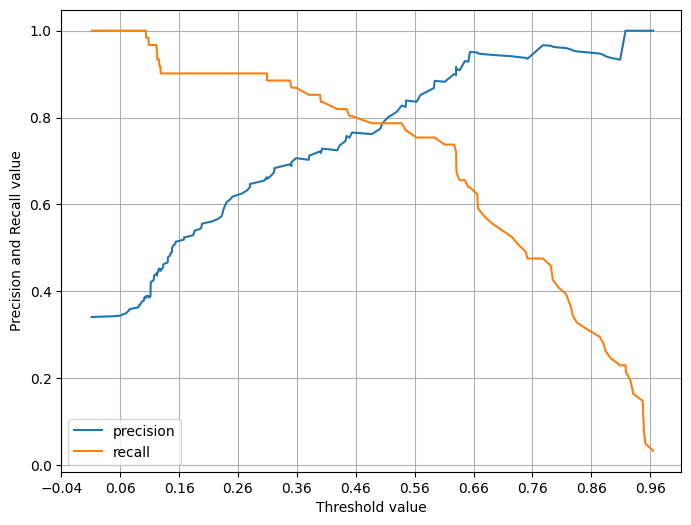

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test, pred_proba_positive):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_positive)

    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, pred_proba_class1)

**결과적으로**
 - 임계값(threshold)이 높아지면 Positive로 예측할 확률이 낮아지고 임계값이 낮아지면 Positive로 예측할 확률이 높아짐
 - 임계값이 낮아지면 TP가 늘고 FN이 줄어든다.

**요약하면**
 - 임계값이 높아지면 precision이 증가한다.
 - 임계값이 낮아지면 recall이 증가한다.

</br>
*임계값을 넘으면 positive, 넘지 못하면 negative

## **F1 스코어**

![img](https://images.velog.io/images/jadon/post/f06f1d40-605d-4f13-b6ce-35c220c82968/image.png)

- 정밀도와 재현율을 결합한 지표로 어느 쪽에도 치우치지 않는 경우 F1 스코어가 높게 나온다.

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
f1

## **ROC 곡선과 AUC**
- skip